In [140]:
import json
from ultralytics.data.converter import convert_coco
import shutil
import os
from ultralytics.data.split import split_classify_dataset
import cv2
from pathlib import Path
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image
import os
import shutil
import random
import numpy as np
import json
import pandas as pd

In [141]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [142]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [143]:
from huggingface_hub import notebook_login

notebook_login()

In [144]:
!mkdir /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [145]:
!git clone https://huggingface.co/datasets/pajama912/FoodLogAthl-218

fatal: destination path 'FoodLogAthl-218' already exists and is not an empty directory.


In [180]:
convert_coco("/content/FoodLogAthl-218/annotations/",
             "/content/dataset/",
             cls91to80 = False)

Annotations /content/FoodLogAthl-218/annotations/instances_coco.json: 100%|██████████| 6925/6925 [00:00<00:00, 7483.64it/s]

COCO data converted successfully.
Results saved to /content/dataset


In [181]:
for image_name in os.listdir("/content/dataset/labels/coco"):
  shutil.move("/content/dataset/labels/coco/" + image_name, "/content/dataset/labels/" + image_name)
shutil.rmtree("/content/dataset/labels/coco")

In [182]:
image_ids = {}

for image_name in os.listdir("/content/dataset/labels"):
  with open("/content/dataset/labels/" + image_name, 'r') as f:
    lines = f.readlines()[0].strip().split(" ")
  image_ids[int(lines[0])] = 1

In [183]:
for image_name in os.listdir("/content/FoodLogAthl-218/images"):
  shutil.copy("/content/FoodLogAthl-218/images/" + image_name, "/content/dataset/images/" + image_name)

In [184]:
imgs = os.listdir("/content/dataset/images")
np.random.shuffle(imgs)
train_imgs = imgs[:int(len(imgs) * 0.9)]
val_imgs = imgs[int(len(imgs) * 0.9):]

In [185]:
os.makedirs("/content/dataset/images/train")
os.makedirs("/content/dataset/labels/train")
os.makedirs("/content/dataset/images/val")
os.makedirs("/content/dataset/labels/val")

In [186]:
for image_name in os.listdir("/content/dataset/images"):
  if image_name not in ['train', 'val']:
    if image_name in train_imgs:
      shutil.copy("/content/dataset/images/" + image_name, "/content/dataset/images/train/" + image_name)
      shutil.copy("/content/dataset/labels/" + image_name[:-4] + ".txt", "/content/dataset/labels/train/" + image_name[:-4] + ".txt")
      os.remove("/content/dataset/images/" + image_name)
      os.remove("/content/dataset/labels/" + image_name[:-4] + ".txt")
    else:
      shutil.copy("/content/dataset/images/" + image_name, "/content/dataset/images/val/" + image_name)
      shutil.copy("/content/dataset/labels/" + image_name[:-4] + ".txt", "/content/dataset/labels/val/" + image_name[:-4] + ".txt")
      os.remove("/content/dataset/images/" + image_name)
      os.remove("/content/dataset/labels/" + image_name[:-4] + ".txt")

In [ ]:
import requests
import json

with open("/root/.kaggle/kaggle.json") as f:
    cred = json.load(f)


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = cred['username']
os.environ['KAGGLE_KEY'] = cred['key']


In [ ]:
len(os.listdir("/content/dataset/train/labels/"))

6232

In [ ]:
len(os.listdir("/content/dataset/train/images"))

6232

In [187]:
img = cv2.imread("/content/dataset/images/train/image_105364.jpg")
annotations = open("/content/dataset/labels/train/image_105364.txt").readlines()

In [188]:
annotations = [annot.strip() for annot in annotations]

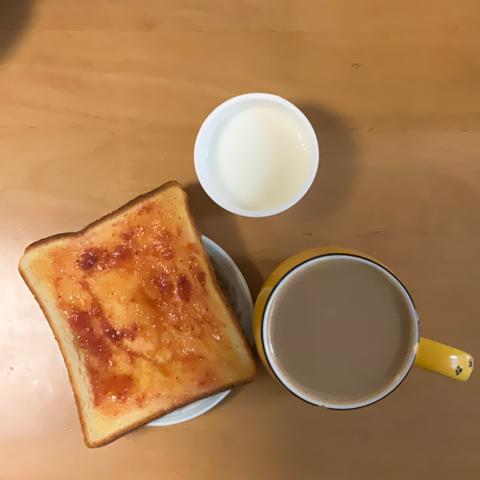

In [189]:
cv2_imshow(img)

In [190]:
def get_annotation(img, label):
  img_height, img_width, _ = img.shape # A safer way to unpack
  for obj in label:
    name, x, y, width, height = obj.split(" ")
    x = float(x)
    y = float(y)
    width = float(width)
    height = float(height)
    x1_real = int(np.abs(x - (width/2)) * img_width)
    x2_real = int(np.abs(x + (width/2)) * img_width)
    y1_real = int(np.abs(y + (height/2)) * img_height)
    y2_real = int(np.abs(y - (height/2)) * img_height)
    color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
    image = cv2.rectangle(img, (x1_real, y2_real), (x2_real, y1_real), color = color, thickness = 2)
    image = cv2.putText(img, name, (x1_real, y2_real), fontFace=cv2.FONT_HERSHEY_DUPLEX,
                      fontScale=1.0, color=(255, 255, 255 ), thickness=2)
  return img

In [191]:
updated_imgs = get_annotation(img, annotations)

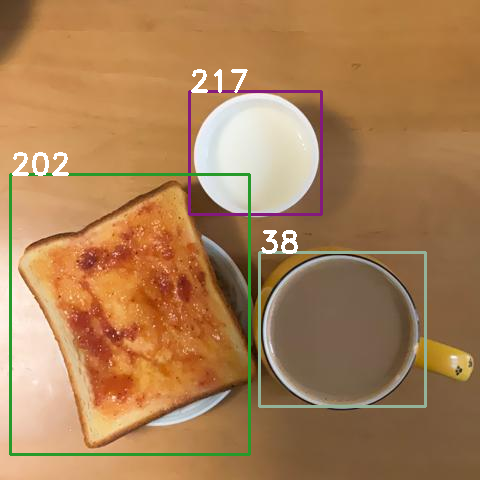

In [192]:
cv2_imshow(updated_imgs)

In [193]:
df = pd.read_csv('/content/FoodLogAthl-218/class_map.csv').to_dict()

In [194]:
labels_classes = df['label']

In [195]:
import yaml

In [196]:
data = {
    'nc': len(labels_classes),
    'train': 'images/train',
    'val': 'images/val',
    'names': labels_classes
}

with open('data.yaml', 'w') as file:
  yaml.dump(data, file, sort_keys=False)

In [197]:
!kaggle datasets init -p /content/dataset/

Data package template written to: /content/dataset/dataset-metadata.json


In [198]:
!kaggle datasets create -p /content/dataset/ -r tar

Starting upload for file labels.tar
100% 13.5M/13.5M [00:00<00:00, 47.3MB/s]
Upload successful: labels.tar (14MB)
Starting upload for file images.tar
100% 273M/273M [00:02<00:00, 103MB/s]
Upload successful: images.tar (273MB)
Starting upload for file data.yaml
100% 3.80k/3.80k [00:00<00:00, 21.3kB/s]
Upload successful: data.yaml (4KB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/bulatsharipov1/food-detection-dataset
